In [1]:
from citalopram_project.load import load_neurons, get_data_dir
import pandas as pd
import seaborn as sns
from citalopram_project.correlations import get_combs
from scipy.stats import mannwhitneyu, ttest_ind
import ezbootstrap as ez
import numpy as np
import warnings
warnings.filterwarnings("ignore")
sns.set()

neurons = load_neurons().loc[lambda x: x.group.isin(["sal", "continuation"])]
df_corr = pd.read_parquet(get_data_dir() / "derived" / "pre_1s_spont_correlation_test.parquet.gzip")
df = get_combs(df_corr.iloc[::-1], neurons[["neuron_id", "cluster"]].dropna()).merge(neurons[["group", "neuron_id"]], left_on="neuron_1", right_on="neuron_id")
df["abs_val"] = df["value"].abs()
df["comb_abv"] = (
    df.comb.str.replace("slow_irregular", "SIR")
    .str.replace("fast_firing", "FF")
    .str.replace("slow_regular", "SR")
    .map({"SR-SR": "SR-SR", "SIR-SR": "SR-SIR", "FF-SR": "SR-FF", "SIR-SIR": "SIR-SIR", "SIR-FF": "SIR-FF", "FF-FF": "FF-FF"})
)
df["is_neg"] = df["value"] < 0

In [2]:
# Correlation mag

def correlation_mag(df):
    stats = {}
    stats["n SAL"] = len(df.loc[lambda x: x.group == "sal"])
    stats["n CIT"] = len(df.loc[lambda x: x.group == "continuation"])
    stats["M SAL"] = df.loc[lambda x: x.group == "sal"]["abs_val"].median()
    sal_se = np.std(ez.bs_1sample(df.loc[lambda x: x.group == "sal"]["abs_val"].values, func=np.median, size=1000))
    
    stats["M CIT"] = df.loc[lambda x: x.group == "continuation"]["abs_val"].median()
    cit_se = np.std(ez.bs_1sample(df.loc[lambda x: x.group == "continuation"]["abs_val"].values, func=np.median, size=1000))

    stats["Diff"] =  stats["M CIT"] - stats["M SAL"]

    stats["M SAL"] = f"{stats['M SAL']:.2f} (+- {sal_se:.2f})"
    stats["M CIT"] = f"{stats['M CIT']:.2f} (+- {cit_se:.2f})"
    stat, p = mannwhitneyu(df.loc[lambda x: x.group == "sal"]["abs_val"], df.loc[lambda x: x.group == "continuation"]["abs_val"])
    stats["U"] = stat
    stats["p"] = np.round(p, 2) 
    stats["p"] = str(stats["p"]) if stats["p"] > 0.05 else f"{stats['p']}*"
    return pd.Series(stats)


print(correlation_mag(df))

with open("rsc_change.md", "w") as f:
    table_mag = df.groupby("comb_abv").apply(correlation_mag).iloc[::-1].round(2)
    table_mag.to_markdown(f)

table_mag

n SAL              2169
n CIT              4019
M SAL    0.16 (+- 0.01)
M CIT    0.13 (+- 0.01)
Diff         -0.0331348
U           3.77683e+06
p                  0.0*
dtype: object


,n SAL,n CIT,M SAL,M CIT,Diff,U,p
comb_abv,,,,,,,
SR-SR,459,894,0.13 (+- 0.01),0.16 (+- 0.01),0.04,176490.0,0.0*
SR-SIR,795,1878,0.16 (+- 0.01),0.12 (+- 0.01),-0.04,625084.0,0.0*
SR-FF,266,126,0.15 (+- 0.01),0.28 (+- 0.01),0.13,11660.0,0.0*
SIR-SIR,391,926,0.23 (+- 0.01),0.10 (+- 0.00),-0.14,99173.0,0.0*
SIR-FF,220,119,0.17 (+- 0.01),0.17 (+- 0.01),0.00,12991.0,0.45
FF-FF,38,76,0.17 (+- 0.02),0.24 (+- 0.01),0.06,1190.0,0.06


In [3]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

mod = smf.ols("abs_val ~ comb_abv", data=df).fit()

sm.stats.anova_lm(mod)

,df,sum_sq,mean_sq,F,PR(>F)
comb_abv,5.0,3.804340,0.760868,28.437363,1.327176e-28
Residual,6182.0,165.405144,0.026756,NaN,NaN


In [4]:
from statsmodels.stats.proportion import proportions_ztest

def prop_neg(df):
    stats = {}
    df = df.loc[lambda x : x["p"] < 0.05]
    stats["n SAL"] = len(df.loc[lambda x: x.group == "sal"])
    stats["n CIT"] = len(df.loc[lambda x: x.group == "continuation"])

    stats["% SAL"] = (df.loc[lambda x: x.group == "sal"]["value"] < 0).mean() * 100
    stats["% CIT"] = (df.loc[lambda x: x.group == "continuation"]["value"] < 0).mean() * 100

    stats["Diff"] = stats["% CIT"] - stats["% SAL"]

    num_sal = (df.loc[lambda x: x.group == "sal"]["value"] < 0).sum()
    num_cit = (df.loc[lambda x: x.group == "continuation"]["value"] < 0).sum()
    stat, p = proportions_ztest([num_sal, num_cit], [stats["n SAL"], stats["n CIT"]])
    stats["Z"] = stat
    stats["p"] = np.round(p, 2) 
    stats["p"] = str(stats["p"]) if stats["p"] > 0.05 else f"{stats['p']}*"

    return pd.Series(stats)

print(prop_neg(df))

with open("rsc_neg.md", "w") as f:
    table_mag = df.groupby("comb_abv").apply(prop_neg).iloc[::-1].round(2)
    table_mag.to_markdown(f)

table_mag

n SAL       1769
n CIT       3018
% SAL     41.662
% CIT    39.5958
Diff     -2.0662
Z        1.40644
p           0.16
dtype: object


,n SAL,n CIT,% SAL,% CIT,Diff,Z,p
comb_abv,,,,,,,
SR-SR,343,728,35.57,40.93,5.37,-1.68,0.09
SR-SIR,644,1362,45.96,41.19,-4.77,2.02,0.04*
SR-FF,217,118,38.25,40.68,2.43,-0.44,0.66
SIR-SIR,345,635,40.87,35.28,-5.59,1.73,0.08
SIR-FF,185,103,44.32,33.98,-10.34,1.71,0.09
FF-FF,35,72,37.14,40.28,3.13,-0.31,0.76


In [5]:
from citalopram_project.load import load_spikes
from citalopram_project.correlations import pairwise_correlation_spikes
from tqdm.notebook import tqdm


neurons = load_neurons()
spikes = load_spikes(block_name="pre").merge(
    neurons[["neuron_id", "session_name", "cluster"]]
)

res = {}
for session in tqdm(neurons["session_name"].unique()):
    df_spikes = spikes.loc[lambda x: x.session_name == session]
    res[session] = (
        pairwise_correlation_spikes(
            df_spikes=df_spikes,
            bin_width=1,
            rectify=True,
            fillna=0,
            sigma=0)
    )

  0%|          | 0/21 [00:00<?, ?it/s]

In [6]:
import networkx as nx
from scipy.stats import zscore



def graph_from_dict(df_corr):
    labels = df_corr.index.values
    values = df_corr.values
    values[values==0] = 0.01

    g = nx.from_numpy_matrix(values)
    g = nx.relabel_nodes(g, lambda x: labels[x])
    return g

def get_degree(df_dict):
    out = []
    for session_name, df_corr in df_dict.items():
        g = graph_from_dict(df_corr)
        df = pd.DataFrame(g.degree(weight="weight"), columns=["neuron_id", "centrality"])
        df2 = pd.DataFrame(list(nx.closeness_centrality(g, distance="weight").items()), columns=["neuron_id", "closeness"])
        df = df.merge(df2)
        df["centrality_norm"] = zscore(df["centrality"])
        df["closeness_norm"] = df["closeness"].divide(len(g.nodes))
        out.append(df.assign(session_name=session_name))
    return pd.concat(out)


df_res = get_degree(res).merge(neurons[["group", "cluster", "neuron_id"]].loc[lambda x: x.group != "discontinuation"]).dropna()

In [7]:
def compare_centrality(df_res, cluster, measure="centrality_norm"):
    dfp = df_res.loc[lambda x: (x.cluster == cluster)]
    x = dfp.loc[lambda x: x.group == "sal"][measure]
    y = dfp.loc[lambda x: x.group == "continuation"][measure]
    return mannwhitneyu(x, y)

sr = compare_centrality(df_res, cluster="slow_regular")
sir = compare_centrality(df_res, cluster="slow_irregular")
ff = compare_centrality(df_res, cluster="fast_firing")
print(sr)
print(sir)
print(ff)

MannwhitneyuResult(statistic=1945.0, pvalue=0.038813206845036606)
MannwhitneyuResult(statistic=1738.0, pvalue=0.002544813736016486)
MannwhitneyuResult(statistic=159.0, pvalue=0.27447876332708177)


In [8]:
clust = "fast_firing"

x = df_res.loc[lambda x: (x.cluster == clust) & (x.group == "sal")]["centrality_norm"].median()
y = df_res.loc[lambda x: (x.cluster == clust) & (x.group == "continuation")]["centrality_norm"].median()

n1 = len(df_res.loc[lambda x: (x.cluster == clust) & (x.group == "sal")])
n2 = len(df_res.loc[lambda x: (x.cluster == clust) & (x.group == "continuation")])
print(x)
print(n1)
print(y)
print(n2)

-0.17846571066863176
20
0.278330488879746
18


In [20]:
mod = smf.ols(data=df_res, formula="centrality_norm ~ group * cluster").fit()

anova_lm(mod)

,df,sum_sq,mean_sq,F,PR(>F)
group,1.0,0.122321,0.122321,0.136253,0.712279
cluster,2.0,0.260456,0.130228,0.145060,0.865027
group:cluster,2.0,10.247885,5.123942,5.707527,0.003668
Residual,320.0,287.280555,0.897752,NaN,NaN


In [21]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        centrality_norm   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     2.368
Date:                Fri, 20 May 2022   Prob (F-statistic):             0.0394
Time:                        15:20:05   Log-Likelihood:                -441.96
No. Observations:                 326   AIC:                             895.9
Df Residuals:                     320   BIC:                             918.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  0.2274      0.223      1.018      0.309      -0.212       0.667
group[T.sal]                              -0.2246      0.308     -0.730      0.466      -0.830       0.381
cluster[T.slow_irregular]                 -0.1980      0.244     -0.812      0.418      -0.678       0.282
cluster[T.slow_regular]                    0.0604      0.244      0.247      0.805      -0.420       0.541
group[T.sal]:cluster[T.slow_irregular]     0.6851      0.349      1.964      0.050      -0.001       1.371
group[T.sal]:cluster[T.slow_regular]      -0.0693      0.349     -0.198      0.843      -0.756       0.618
==============================================================================
Omnibus:                       29.949   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.781
Skew:                           0.033   Prob(JB):                      0.00752
Kurtosis:                       2.154   Cond. No.                         15.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
from citalopram_project.load import get_data_dir
from statsmodels.stats.anova import anova_lm

df_eeg = pd.read_csv(get_data_dir() / "derived" / "eeg_corr.csv")

mod = df_eeg.merge(df_res).pipe((smf.ols, "data"), formula="centrality_norm ~ abs_eeg_corr * group * cluster").fit()

anova_lm(mod).round(3)
# mod.summary()

,df,sum_sq,mean_sq,F,PR(>F)
group,1.0,1.304,1.304,1.777,0.184
cluster,2.0,2.185,1.092,1.488,0.228
group:cluster,2.0,5.474,2.737,3.729,0.025
abs_eeg_corr,1.0,52.960,52.960,72.162,0.000
abs_eeg_corr:group,1.0,2.731,2.731,3.722,0.055
abs_eeg_corr:cluster,2.0,1.153,0.577,0.786,0.457
abs_eeg_corr:group:cluster,2.0,0.231,0.116,0.158,0.854
Residual,257.0,188.612,0.734,NaN,NaN


In [80]:
def get_footshock_val(derived_data_dir):
    return pd.read_csv(derived_data_dir / "footshock_slow_timescale.csv").assign(
        footshock_val=lambda x: np.where(x["statistic"] < 0, "activated", "inhibited")
    )[["neuron_id", "footshock_val"]]


def get_footshock_mag(derived_data_dir):
    return pd.read_csv(derived_data_dir / "footshock_fast_timescale.csv").assign(
        footshock_mag=lambda x: x["Observed Difference"].abs()
    )[["neuron_id", "footshock_mag"]]


def get_eeg_val(derived_data_dir):
    return pd.read_csv(derived_data_dir / "eeg_corr.csv").assign(
        eeg_val=lambda x: np.where(x.eeg_corr < 0, "negative", "positive")
    )[["neuron_id", "eeg_val"]]


def get_eeg_mag(derived_data_dir):
    return pd.read_csv(derived_data_dir / "eeg_corr.csv")[["neuron_id", "abs_eeg_corr"]]

In [99]:
derived_data_dir = get_data_dir() / "derived"
footshock_val = get_footshock_val(derived_data_dir)
footshock_mag = get_footshock_mag(derived_data_dir)

eeg_val = get_eeg_val(derived_data_dir)
eeg_mag = get_eeg_mag(derived_data_dir)

neuron_props = neurons[["neuron_id", "session_name", "group", "cluster"]].merge(df_res)
neuron_props_eeg = neuron_props.merge(eeg_val).merge(eeg_mag).merge(df_res)
neuron_props_footshock = neuron_props.merge(footshock_val).merge(footshock_mag).merge(df_res)
neuron_props_all = neuron_props.merge(neuron_props_eeg).merge(neuron_props_footshock).merge(df_res)

neuron_props.to_csv(derived_data_dir / "centralities_clust.csv", index=False)
neuron_props_all.to_csv(derived_data_dir / "centralities_all.csv", index=False)
neuron_props_eeg.to_csv(derived_data_dir / "centralities_eeg.csv", index=False)
neuron_props_footshock.to_csv(derived_data_dir / "centralities_footshock.csv", index=False)

In [96]:
neuron_props.to_csv(derived_data_dir / "centralities_all.csv", index=False)

In [91]:
mod = smf.ols("centrality_norm ~ group + footshock_val + eeg_val + footshock_mag + abs_eeg_corr + cluster + footshock_val:group + footshock_val:cluster + footshock_val:cluster:group + footshock_mag:group + footshock_mag:cluster + footshock_mag:cluster:group + eeg_val:group + eeg_val:cluster + eeg_val:group:cluster + abs_eeg_corr:group + abs_eeg_corr:cluster + abs_eeg_corr:group:cluster + cluster:group", data=neuron_props).fit()
anova_lm(mod).round(3)

,df,sum_sq,mean_sq,F,PR(>F)
group,1.0,0.982,0.982,1.443,0.231
footshock_val,1.0,4.052,4.052,5.955,0.016
eeg_val,1.0,31.540,31.540,46.358,0.000
cluster,2.0,2.511,1.256,1.845,0.161
footshock_val:group,1.0,1.565,1.565,2.300,0.131
footshock_val:cluster,2.0,0.659,0.329,0.484,0.617
eeg_val:group,1.0,0.936,0.936,1.375,0.242
eeg_val:cluster,2.0,0.727,0.364,0.535,0.587
cluster:group,2.0,7.123,3.561,5.235,0.006
footshock_val:cluster:group,2.0,1.183,0.591,0.869,0.421


In [94]:
mod = smf.ols("centrality_norm ~ group + footshock_val + eeg_val + footshock_mag + abs_eeg_corr + cluster + footshock_val:group + footshock_mag:group +  eeg_val:group + abs_eeg_corr:group + cluster:group", data=neuron_props).fit()
anova_lm(mod).round(3)

,df,sum_sq,mean_sq,F,PR(>F)
group,1.0,0.982,0.982,1.479,0.225
footshock_val,1.0,4.052,4.052,6.103,0.014
eeg_val,1.0,31.540,31.540,47.511,0.000
cluster,2.0,2.511,1.256,1.891,0.154
footshock_val:group,1.0,1.565,1.565,2.357,0.126
eeg_val:group,1.0,0.978,0.978,1.473,0.226
cluster:group,2.0,7.429,3.714,5.595,0.004
footshock_mag,1.0,3.581,3.581,5.394,0.021
footshock_mag:group,1.0,0.030,0.030,0.045,0.833
abs_eeg_corr,1.0,18.173,18.173,27.375,0.000


In [92]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        centrality_norm   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     4.529
Date:                Fri, 20 May 2022   Prob (F-statistic):           1.08e-09
Time:                        16:22:15   Log-Likelihood:                -251.61
No. Observations:                 216   AIC:                             553.2
Df Residuals:                     191   BIC:                             637.6
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            -0.8450      0.355     -2.380      0.018      -1.545      -0.145
group[T.sal]                                                         -0.2817      0.355     -0.793      0.428      -0.982       0.419
footshock_val[T.inhibited]                                            0.3199      0.312      1.024      0.307      -0.296       0.936
eeg_val[T.positive]                                                  -0.2154      0.335     -0.642      0.521      -0.877       0.446
cluster[T.slow_irregular]                                             0.4576      0.397      1.152      0.251      -0.326       1.241
cluster[T.slow_regular]                                               0.4578      0.401      1.140      0.256      -0.334       1.250
footshock_val[T.inhibited]:group[T.sal]                               0.2322      0.312      0.743      0.458      -0.384       0.848
footshock_val[T.inhibited]:cluster[T.slow_irregular]                 -0.2946      0.354     -0.832      0.406      -0.993       0.404
footshock_val[T.inhibited]:cluster[T.slow_regular]                   -0.0508      0.351     -0.145      0.885      -0.743       0.642
eeg_val[T.positive]:group[T.sal]                                      0.3647      0.335      1.088      0.278      -0.297       1.026
eeg_val[T.positive]:cluster[T.slow_irregular]                        -0.6055      0.374     -1.620      0.107      -1.343       0.132
eeg_val[T.positive]:cluster[T.slow_regular]                          -0.5095      0.370     -1.377      0.170      -1.239       0.220
cluster[T.slow_irregular]:group[T.sal]                                0.9580      0.468      2.045      0.042       0.034       1.882
cluster[T.slow_regular]:group[T.sal]                                  0.5207      0.472      1.104      0.271      -0.410       1.451
footshock_val[T.inhibited]:cluster[T.slow_irregular]:group[T.sal]    -0.1201      0.417     -0.288      0.774      -0.943       0.703
footshock_val[T.inhibited]:cluster[T.slow_regular]:group[T.sal]      -0.3129      0.406     -0.770      0.442      -1.114       0.488
eeg_val[T.positive]:group[T.sal]:cluster[T.slow_irregular]           -0.0751      0.441     -0.170      0.865      -0.946       0.796
eeg_val[T.positive]:group[T.sal]:cluster[T.slow_regular]             -0.4599      0.433     -1.062      0.289      -1.314       0.394
footshock_mag                                                         0.0256      0.014      1.780      0.077      -0.003       0.054
footshock_mag:group[T.sal]                                            0.0062      0.014      0.428      0.669      -0.022       0.035
f

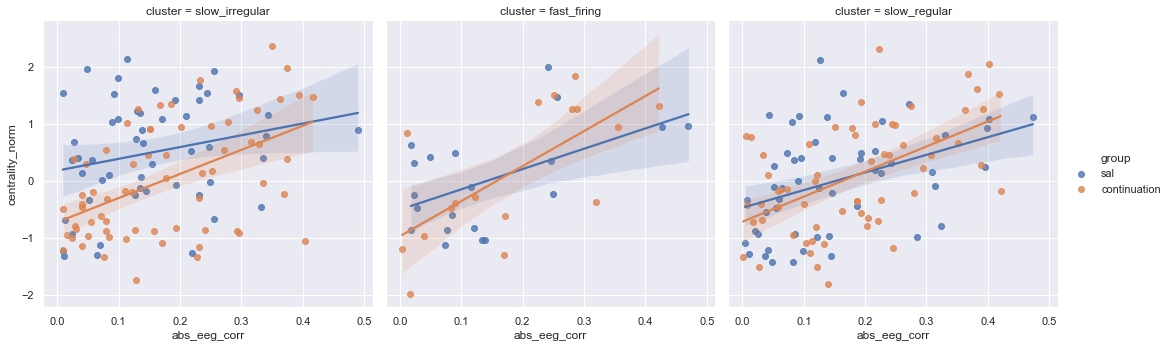

In [38]:
from scipy.stats import pearsonr


g = sns.lmplot(x="abs_eeg_corr", y="centrality_norm", hue="group", data=df_eeg.merge(df_res), col="cluster")



In [23]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        centrality_norm   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     16.16
Date:                Fri, 20 May 2022   Prob (F-statistic):           6.79e-14
Time:                        15:22:31   Log-Likelihood:                -338.28
No. Observations:                 269   AIC:                             688.6
Df Residuals:                     263   BIC:                             710.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.8315      0.188     -4.429      0.000      -1.201      -0.462
group[T.sal]                  0.5470      0.183      2.995      0.003       0.187       0.907
cluster[T.slow_irregular]     0.1709      0.162      1.052      0.294      -0.149       0.491
cluster[T.slow_regular]      -0.0297      0.163     -0.182      0.856      -0.351       0.292
abs_eeg_corr                  4.5823      0.599      7.649      0.000       3.403       5.762
group[T.sal]:abs_eeg_corr    -1.7474      0.903     -1.934      0.054      -3.526       0.031
==============================================================================
Omnibus:                        5.945   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                3.561
Skew:                           0.052   Prob(JB):                        0.169
Kurtosis:                       2.446   Cond. No.                         25.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
df_res.groupby(["group", "cluster"])["centrality_norm"].mean()

group         cluster       
continuation  fast_firing       0.227354
              slow_irregular    0.029354
              slow_regular      0.287797
sal           fast_firing       0.002755
              slow_irregular    0.489891
              slow_regular     -0.006100
Name: centrality_norm, dtype: float64

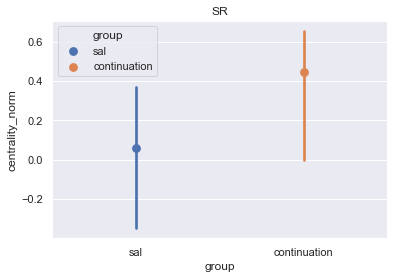

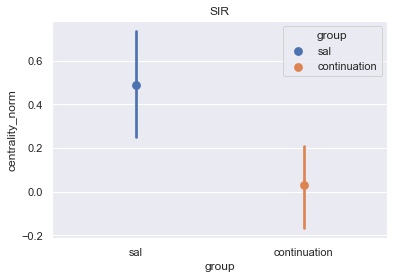

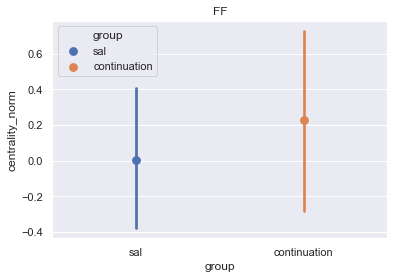

In [45]:
import matplotlib.pyplot as plt

sns.pointplot(
    data=df_res.loc[lambda x: x.cluster == "slow_regular"], 
    x="group", y="centrality_norm", hue="group",
    estimator=np.median)
# )
plt.title("SR")
plt.show()

sns.pointplot(
    data=df_res.loc[lambda x: x.cluster == "slow_irregular"], 
    x="group", y="centrality_norm", hue="group",
    # estimator=np.median)
)
plt.title("SIR")
plt.show()

sns.pointplot(
    data=df_res.loc[lambda x: x.cluster == "fast_firing"], 
    x="group", y="centrality_norm", hue="group",
    # estimator=np.median)
)
plt.title("FF")
plt.show()

In [46]:
from citalopram_project.network import small_word_propensity

def get_swp(df_dict, weight="weight"):
    def _add_distance(g):
        for n1, n2, d in g.edges(data=True):
            g[n1][n2]["distance"] = 1 / d[weight]
        return g

    out = []
    for session_name, df_corr in df_dict.items():
        res = dict(session_name=session_name)
        g = graph_from_dict(df_corr)
        phi, delta, delta_C, delta_L = small_word_propensity(g)
        clustering = nx.average_clustering(g, weight=weight)
        g = _add_distance(g)
        path_length = nx.average_shortest_path_length(g, weight="distance")
        res["phi"] = phi
        res["delta"] = delta
        res["delta_C"] = delta_C
        res["delta_L"] = delta_L
        res["clustering"] = clustering
        res["path_length"] = path_length
        out.append(res)

    return pd.DataFrame(out)

df_res = get_swp(res)



In [47]:
df_res = load_neurons()[["session_name", "group"]].drop_duplicates().merge(df_res).loc[lambda x: x.group != "discontinuation"]

MannwhitneyuResult(statistic=10.0, pvalue=0.1278115537732063)
5
7
0.26613611716381746
0.28285476099022466


<AxesSubplot:xlabel='group', ylabel='phi'>

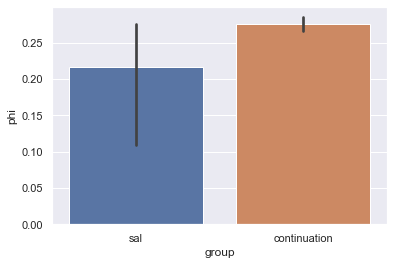

In [49]:
import seaborn as sns
from scipy.stats import mannwhitneyu


x = df_res.loc[lambda x: x.group == "sal"]["phi"]
y = df_res.loc[lambda x: x.group == "continuation"]["phi"]

print(mannwhitneyu(x, y))
print(len(x))
print(len(y))
print(x.median())
print(y.median())

sns.barplot(data=df_res, x="group", y="phi")

MannwhitneyuResult(statistic=17.0, pvalue=0.5)
5
7
0.11897551793265286
0.09461406126382874
MannwhitneyuResult(statistic=17.0, pvalue=0.5)


<AxesSubplot:xlabel='group', ylabel='clustering'>

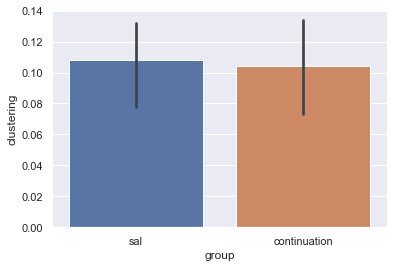

In [51]:
x = df_res.loc[lambda x: x.group == "sal"]["clustering"]
y = df_res.loc[lambda x: x.group == "continuation"]["clustering"]


print(mannwhitneyu(x, y))
print(len(x))
print(len(y))
print(x.median())
print(y.median())

print(mannwhitneyu(x, y))
sns.barplot(data=df_res, x="group", y="clustering")

MannwhitneyuResult(statistic=10.0, pvalue=0.1278115537732063)
5
7
9.75752031783756
8.328828375410543


<AxesSubplot:xlabel='group', ylabel='path_length'>

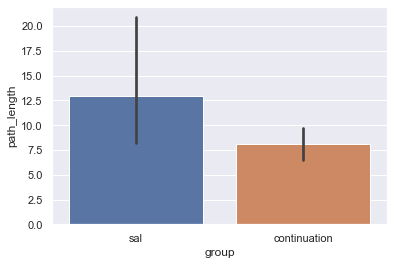

In [52]:
x = df_res.loc[lambda x: x.group == "sal"]["path_length"]
y = df_res.loc[lambda x: x.group == "continuation"]["path_length"]

print(mannwhitneyu(x, y))
print(len(x))
print(len(y))
print(x.median())
print(y.median())
sns.barplot(data=df_res, x="group", y="path_length")